In [1]:
!date

Wed May 31 11:18:51 EDT 2023


In [2]:
pwd

'/mmfs1/data/aglinska/BC-actionpred-seg'

In [3]:
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random
cudnn.benchmark = True
plt.ion()   # interactive m
from datetime import datetime
now = datetime.now
T0 = now()

from IPython import display
import sys
import seaborn as sns

import pickle

In [4]:
from torchvision.models import resnet50
from torch.utils.data import Dataset, DataLoader
#from torchvision.models import resnet50, ResNet50_Weights

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [6]:
torch.cuda.get_device_name(0)

'Tesla V100-SXM2-16GB'

In [7]:
class HAA_dataset(Dataset):
    "Video frame Dataset"
    def __init__(self,data_dir,usage='train'):
        self.data_dir = data_dir
        self.categories = os.listdir(self.data_dir)
        self.categories.sort()
        self.n_cat = len(self.categories)
        self.usage = usage
        
        ## To make test and val, deterministic
        ## Works on images
        ## doest seem to affect transforms
        if self.usage=='train':
            seed = np.random.randint(2147483647) 
            random.seed(seed) 
            torch.manual_seed(seed)
            np.random.seed(seed)
        else:
            seed = 42
            random.seed(seed) 
            torch.manual_seed(seed)
            np.random.seed(seed)
        
        frames = []
        for category in self.categories:
            folder_frames = [frame for frame in os.listdir(os.path.join(data_dir,category)) if not frame.startswith('.')]
            folder_frames.sort()
            frames.append(folder_frames)
        self.frames = frames
        
        self.Ts = transforms.Compose([transforms.ColorJitter(brightness=.3, contrast=.3, saturation=.3, hue=.3),
        transforms.GaussianBlur(kernel_size=(5,9), sigma=(0.1, 2.0))])
        
    def __len__(self):
        return 10_000 # 
        
    def __getitem__(self, idx):
        
        self.rand_cat = np.random.randint(low=0,high=self.n_cat)
        self.rand_frame = np.random.randint(low=0,high=len(self.frames[self.rand_cat]))
        fn = os.path.join(self.data_dir,self.categories[self.rand_cat],self.frames[self.rand_cat][self.rand_frame])
        im = Image.open(fn)
        im = Ts(im)
        im = np.array(im)
        im = im/255
        im = im.swapaxes(2,1).swapaxes(0,1)
        
        #sample = {'image': torch.from_numpy(image).float(), 'label': torch.from_numpy(label).float()}  # make a dict with the image and the correct label
        sample = {'image': torch.from_numpy(im).float(), 'label': torch.from_numpy(np.array([self.rand_cat])).float()}  # make a dict with the image and the correct label
        return sample
    
    
    def get_im(self,rand_cat,frame_idx=None):
        self.rand_cat = rand_cat
        
        if type(frame_idx)==type(None): # For training, randomly choose image
            self.rand_frame = np.random.randint(low=0,high=len(self.frames[self.rand_cat]))
        else: # For val and test, deterministic 
            self.rand_frame = np.mod(frame_idx,len(self.frames[self.rand_cat])) # a spell that loops over array infinitely
            
        fn = os.path.join(self.data_dir,self.categories[self.rand_cat],self.frames[self.rand_cat][self.rand_frame])
        im = Image.open(fn)
        
        if self.usage=='train': # if training, add transforms for data augmentation
            im = self.Ts(im)
            
        im = np.array(im)
        im = im/255
        im = im.swapaxes(2,1).swapaxes(0,1)
        
        return im
    
    def get_batch(self,batch_size):
        self.this_batch_cats = np.random.randint(low=0,high=self.n_cat,size=batch_size)
        self.this_batch_cats = np.array(self.this_batch_cats)
        self.this_batch_im = [self.get_im(i) for i in self.this_batch_cats]
        self.this_batch_im = np.array(self.this_batch_im)
        sample = {'image': torch.from_numpy(self.this_batch_im).float(), 'label': torch.from_numpy(self.this_batch_cats).float()}  # make a dict with the image and the correct label
        return sample

In [8]:
train_dataset = HAA_dataset('./Data/pytorch-data/xl_121_15_action_data_orig/train',usage='train')
val_dataset = HAA_dataset('./Data/pytorch-data/xl_121_15_action_data_orig/val',usage='val')
test_dataset = HAA_dataset('./Data/pytorch-data/xl_121_15_action_data_orig/test',usage='test')

In [9]:
train_dataset.n_cat

121

In [10]:
net = resnet50()
net.fc = nn.Linear(net.fc.in_features,train_dataset.n_cat)

net = net.to(device)
net.half();

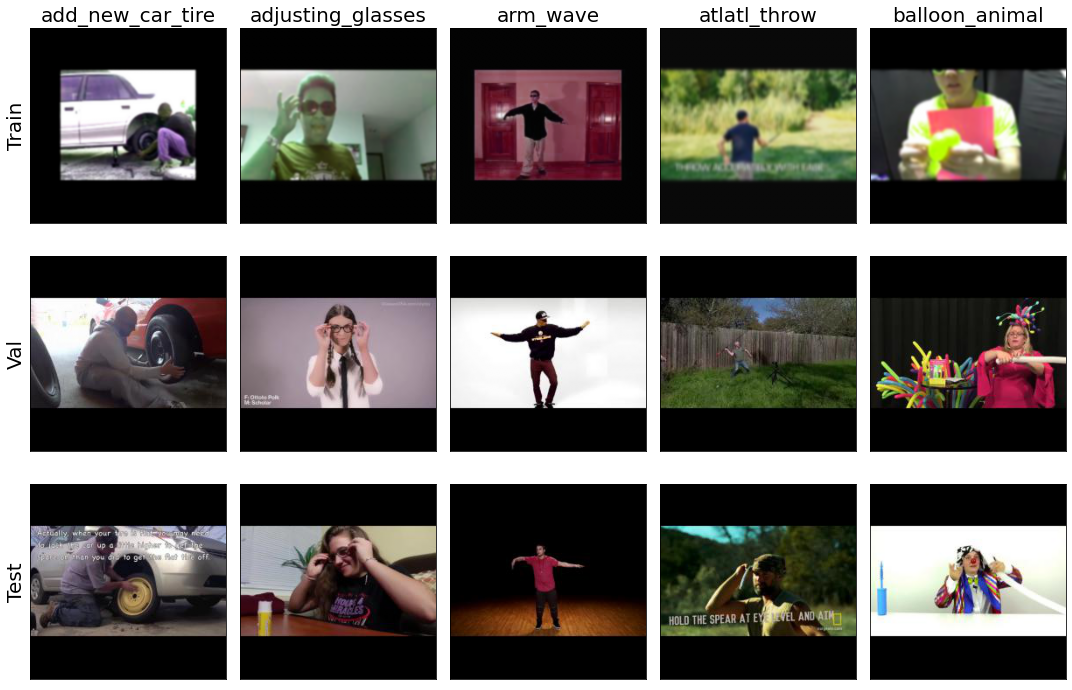

In [11]:
plt.figure(figsize=(15,10))
choose_cats = np.arange(5)

for i in range(5):
    plt.subplot(3,5,i+1)
    plt.imshow(train_dataset.get_im(choose_cats[i]).swapaxes(0,1).swapaxes(1,2))
    plt.title(train_dataset.categories[choose_cats[i]],fontsize=20)
    if i==0:
        plt.ylabel('Train',fontsize=20)
    plt.xticks([]);plt.yticks([])
    
for i in range(5):
    plt.subplot(3,5,i+1+5)
    plt.imshow(val_dataset.get_im(choose_cats[i]).swapaxes(0,1).swapaxes(1,2))
    #plt.axis('off')
    if i==0:
        plt.ylabel('Val',fontsize=20)
    plt.xticks([]);plt.yticks([])
    
for i in range(5):
    plt.subplot(3,5,i+1+10)
    plt.imshow(test_dataset.get_im(choose_cats[i]).swapaxes(0,1).swapaxes(1,2))
    #plt.axis('off')
    if i==0:
        plt.ylabel('Test',fontsize=20)
    plt.xticks([]);plt.yticks([])
    
plt.tight_layout()

In [12]:
save_dir = './Data/pytorch-data/weights/xl_121_15_run_2'

In [19]:
net.load_state_dict(torch.load(os.path.join(save_dir,'weights')));
#net.load_state_dict(torch.load(os.path.join(save_dir,'weights'),map_location=torch.device('cpu')));
net.half() # For GPU
#net.double()
net.eval()

loss_memory = np.load(os.path.join(save_dir,'loss_memory.npy'))
val_memory = np.load(os.path.join(save_dir,'val_memory.npy'))
val_acc = np.load(os.path.join(save_dir,'val_acc.npy'))
val_acc5 = np.load(os.path.join(save_dir,'val_acc5.npy'))
train_acc = np.load(os.path.join(save_dir,'train_acc.npy'))

In [14]:
which_dataset = test_dataset

In [20]:
def get_outputs(which_dataset):
    all_outputs = []
    for c in tqdm( range(which_dataset.n_cat) ):
        category_outputs = []
        for f in range( len( which_dataset.frames[c] ) ):
            #im = torch.tensor(which_dataset.get_im(c,f)[np.newaxis,:,:,:]) # For CPU
            #im = im.double() # For CPU
            im = torch.tensor(which_dataset.get_im(c,f)[np.newaxis,:,:,:]).half().cuda()
            pred = net(im)
            pred = nn.functional.softmax(pred,dim=1)
            pred = pred.detach().cpu().numpy()[0]
            category_outputs.append( pred )
        all_outputs.append( category_outputs )
        
    return all_outputs

In [21]:
# train_dataset = HAA_dataset('./Data/pytorch-data/xl_121_15_action_data_orig/train',usage='train')
# val_dataset = HAA_dataset('./Data/pytorch-data/xl_121_15_action_data_orig/val',usage='val')
# test_dataset = HAA_dataset('./Data/pytorch-data/xl_121_15_action_data_orig/test',usage='test')

In [25]:
calc_test = True

if calc_test==True:
    test_dataset_orig = HAA_dataset('./Data/pytorch-data/xl_121_15_action_data_orig/test',usage='test')
    test_dataset_bg = HAA_dataset('./Data/pytorch-data/xl_121_15_action_data_bg/test',usage='test')
    test_dataset_seg = HAA_dataset('./Data/pytorch-data/xl_121_15_action_data_seg/test',usage='test')

    outputs_test_orig = get_outputs(test_dataset_orig)
    outputs_test_bg = get_outputs(test_dataset_bg)
    outputs_test_seg = get_outputs(test_dataset_seg)

    with open('./Data/outputs_outputs_test_orig_GPU.pickle', 'wb') as handle:
        pickle.dump(outputs_test_orig, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open('./Data/outputs_outputs_test_bg_GPU.pickle', 'wb') as handle:
        pickle.dump(outputs_test_bg, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open('./Data/outputs_outputs_test_seg_GPU.pickle', 'wb') as handle:
        pickle.dump(outputs_test_seg, handle, protocol=pickle.HIGHEST_PROTOCOL)

100%|█████████████████████████████████████████| 121/121 [03:54<00:00,  1.94s/it]


In [23]:
calc_val = True

if calc_val==True:
    val_dataset_orig = HAA_dataset('./Data/pytorch-data/xl_121_15_action_data_orig/val',usage='val')
    val_dataset_bg = HAA_dataset('./Data/pytorch-data/xl_121_15_action_data_bg/val',usage='val')
    val_dataset_seg = HAA_dataset('./Data/pytorch-data/xl_121_15_action_data_seg/val',usage='val')

    outputs_val_orig = get_outputs(val_dataset_orig)
    outputs_val_bg = get_outputs(val_dataset_bg)
    outputs_val_seg = get_outputs(val_dataset_seg)

    with open('./Data/outputs_outputs_val_orig.pickle', 'wb') as handle:
        pickle.dump(outputs_val_orig, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open('./Data/outputs_outputs_val_bg.pickle', 'wb') as handle:
        pickle.dump(outputs_val_bg, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open('./Data/outputs_outputs_val_seg.pickle', 'wb') as handle:
        pickle.dump(outputs_val_seg, handle, protocol=pickle.HIGHEST_PROTOCOL)

100%|█████████████████████████████████████████| 121/121 [02:22<00:00,  1.18s/it]
